Reference: Piasecka, E. et al. Natural variation in the parameters of innate immune cells is preferentially driven by genetic factors resource. Nat. Immunol. 19, 302-314 (2018). Piasecka, B. et al. Distinctive roles of age, sex, and genetics in shaping transcriptional variation of human immune responses to microbial challenges. Proc. Natl. Acad. Sci. 115, E488-E497 (2018). и http://www.milieuinterieur.fr/

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import warnings
import numpy as np
import itertools
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import scale, OneHotEncoder
from sklearn.metrics import explained_variance_score, mean_squared_log_error, r2_score
from sklearn.model_selection import train_test_split
from scipy.stats import linregress
import statsmodels.formula.api as smf
warnings.filterwarnings("ignore")
%matplotlib inline

Данный датасет представляет собой рнк-секвенирование иммуного ответа пациентов на различные стимулы  (Escherichia coli, BCG, Staphylococcus aureus, SEB, Candida albicans and Influenza virus). В данном исследование были секвенированы 560 генов. Основная задача - оценить, насколько может быть вариабелен иммунный ответ в рамках популяции (пусть даже выборка тут небольшая)

Первые колонки, которые в своем названии содержат MFI - это не гены, это усредненный показатель наличиние антитела Н в популяции клеток К. Например, CD38_MFI_in_Bcells  показывает уровень CD38 в B-лимфоцитах. Данные показатели и будут показывать "уровень" имунного ответа. Чем больше этот показатель - тем больше клеток такого типа мы наблюдаем. 
В данной работе мы сосредоточимся на следующийх генах - IFNA2 (возраст) IFNG(возраст),  MAPK14, GATA3

In [2]:
dt = pd.read_csv('dataset_merged.txt',sep='\t')
dt.head()

,id,MFI_CD16_in_CD16hi_of_NKnew.panel4,MFI_CD16_of_CD56hi_of_NKnew.panel4,MFI_CD69_in_CD16hi.panel4,MFI_CD69_in_CD56hi.panel4,MFI_CD8a_in_CD16hi.panel4,MFI_CD8a_in_CD56hi.panel4,MFI_HLADR_in_CD16hi.panel4,MFI_HLADR_in_CD56hi.panel4,MFI_NKp46_of_NK_cells.panel4,...,GUSB,HPRT1,OAZ1,POLR1B,POLR2A,PPIA,RPL19,SDHA,TBP,stimulus
0,2,31186.0,1910.0,605.0,660.0,4654.0,1446.0,478.0,117.0,2596.0,...,6.539184,9.394277,12.764243,6.876416,9.436988,7.149816,13.905253,7.594909,8.345415,E.coli
1,2,31186.0,1910.0,605.0,660.0,4654.0,1446.0,478.0,117.0,2596.0,...,6.383923,8.645649,12.621510,5.879742,9.246874,7.109284,13.705402,7.602972,7.897460,NS
2,2,31186.0,1910.0,605.0,660.0,4654.0,1446.0,478.0,117.0,2596.0,...,6.981202,9.393463,12.731546,6.761389,9.501816,7.038248,13.986449,7.607074,8.415745,S.aureus
3,2,31186.0,1910.0,605.0,660.0,4654.0,1446.0,478.0,117.0,2596.0,...,6.167420,8.826709,12.313861,6.004913,9.191683,6.747720,13.113442,7.184175,8.011676,IAV
4,2,31186.0,1910.0,605.0,660.0,4654.0,1446.0,478.0,117.0,2596.0,...,6.319617,9.093092,12.859986,6.586251,9.716243,7.125948,14.220541,7.299251,8.183092,BCG


Проведем небольшую разминку - построим графики, посмотрим на распределения, проведем тесты, посчитаем статистики. 

У нас есть дополнительная информация. Самые интересные из колонок:
 - Age
 - PhysicalActivity
 - Sex
 - MetabolicScore
 - HoursOfSleep
 - UsesCannabis
 - Smoking
 - BMI

 Посмотрим на распределение возрастов и пола

In [3]:
metadata_columns = ['id','Age','PhysicalActivity','Sex','MetabolicScore','BMI','HoursOfSleep','UsesCannabis',\
                    'Smoking','Employed','Education','DustExposure']
ids_description  = dt.drop_duplicates('id').drop(['stimulus'],axis=1)[metadata_columns]
ids_description.head()

,id,Age,PhysicalActivity,Sex,MetabolicScore,BMI,HoursOfSleep,UsesCannabis,Smoking,Employed,Education,DustExposure
0,2,22.33,3.0,Female,0,20.13,9.00,No,Never,No,PhD,No
7,3,28.83,0.0,Female,1,21.33,7.05,No,Active,Yes,Baccalaureat,No
14,4,23.67,0.0,Female,2,22.18,6.50,Yes,Active,Yes,Baccalaureat,Current
21,5,21.17,0.5,Female,0,18.68,10.00,No,Never,No,PhD,No
28,8,26.17,1.5,Female,1,29.01,9.00,No,Never,Yes,Baccalaureat,No


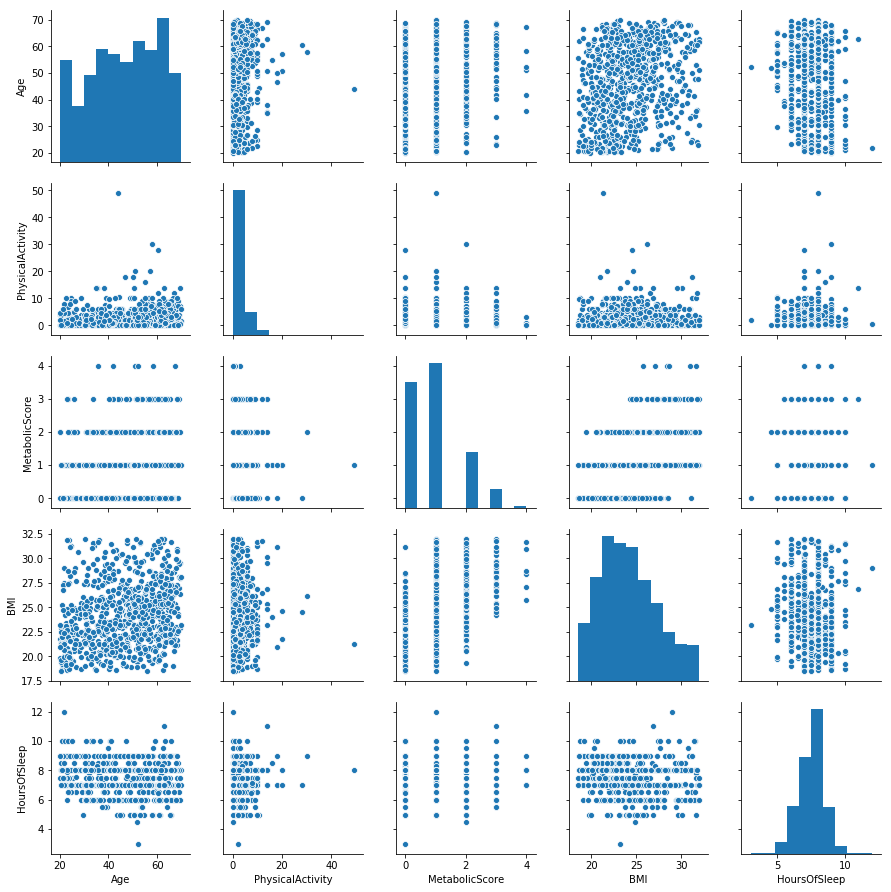

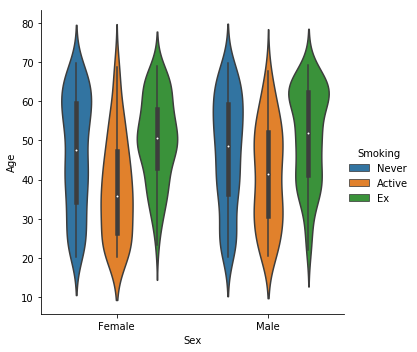

In [4]:
sns.pairplot(ids_description[['Age','PhysicalActivity','MetabolicScore','BMI','HoursOfSleep']]);
plt.show()
sns.catplot(x="Sex", y="Age", hue="Smoking",data=ids_description,kind="violin");

В принципе, данные довольно сбалансированные. Не удивительно, ведь авторы исследования так и пытались сделать. 
Теперь начнем смотреть на экспрессии генов и их связь с возрастом\полом\статусом.

3.1 Сравнение экспресии IFNG у мужчин и женщин

3.1.1 Рассмотрим распределение экспресси IFNG у женщин (со стимулом - S.aureus). На что похоже это распределение? Как это проверить? 

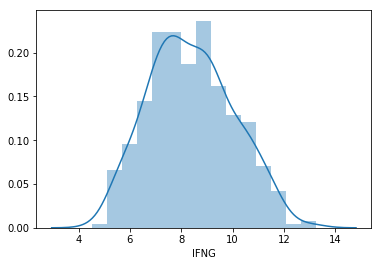

In [5]:
mask = (dt['Sex']=='Female') & (dt['stimulus']=='S.aureus')
sns.distplot(dt.loc[mask,'IFNG']);

Какое удивительное нормальные распределение! Давайте проверим, что оно нормальное

p value 0.005840549245476723


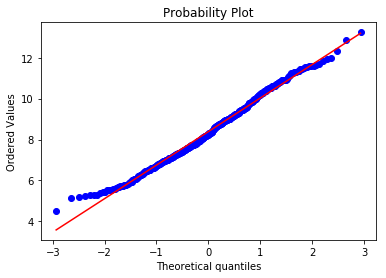

In [6]:
k2, p = sc.stats.shapiro(dt.loc[mask,'IFNG'].values)
print('p value {}'.format(p))
sc.stats.probplot(dt.loc[mask,'IFNG'].values,plot=plt);

 Оценим параметры этого распределения.

In [7]:
d_var = np.var(dt.loc[mask,'IFNG'].values)
d_mean = np.mean(dt.loc[mask,'IFNG'].values)
print('mean {}, var {}'.format(d_mean, d_var))

mean 8.38686991239565, var 2.6778212676547954


Задача 1. Сделать аналогичные шаги для мужчин (со стимулом - S.aureus)

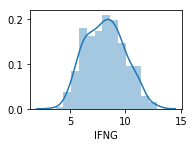

p value 0.008007435128092766
mean 8.169332888011015, var 3.049249527483538


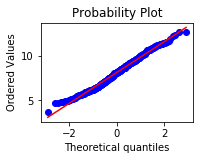

In [8]:
#Task 1 solution
ax1 = plt.subplot(221)
mask = (dt['Sex']=='Male') & (dt['stimulus']=='S.aureus')
sns.distplot(dt.loc[mask,'IFNG'],ax=ax1);
plt.show();
k2, p = sc.stats.shapiro(dt.loc[mask,'IFNG'].values)
print('p value {}'.format(p))
d_var = np.var(dt.loc[mask,'IFNG'].values)
d_mean = np.mean(dt.loc[mask,'IFNG'].values)
#Funny fact - outliers ruin normaltest?
ax2 = plt.subplot(223)
sc.stats.probplot(dt.loc[mask,'IFNG'].values, plot=plt);
print('mean {}, var {}'.format(d_mean, d_var))

Задача 2. Давайте используем бустреп чтобы оценить доверительный интервал для среднего уровня экспресии гена
IFNG у мужчин и женщин. Используем 1000 итераций, будем семплить по 100 точек. Давайте условимся, что в этот раз работаем со стимулом E.coli

Boostrap for Male
for Male, 95.0 confidence interval 9.132643591742575 and 9.15481071597602
Boostrap for Female
for Female, 95.0 confidence interval 9.31605678379434 and 9.33658141892864


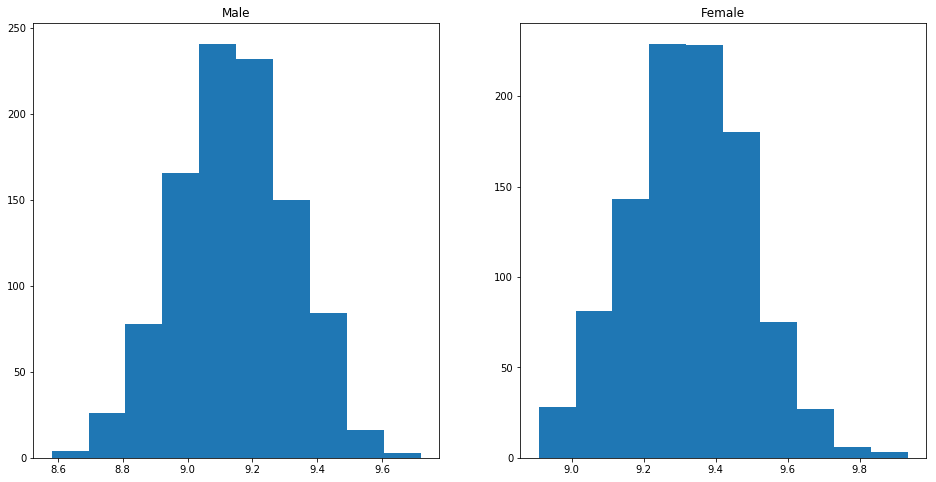

In [9]:
#Task 2 solution
stats = {'Male':list(),'Female':list()}
n_iterations = 1000
n_size = 100
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), sc.stats.sem(a)
    h = se * sc.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h
f, ax = plt.subplots(1, 2, figsize=(16, 8))
for idx, sex in enumerate(['Male', 'Female']):
    print('Boostrap for {}'.format(sex))
    mask = (dt['Sex']==sex) & (dt['stimulus']=='E.coli')
    values_expression = dt.loc[mask,'IFNG'].values
    for i in range(n_iterations):
    # prepare train and test sets
        sample = np.random.choice(values_expression, size=n_size, replace=True)
        stats[sex].append(np.mean(sample))
    ax[idx].hist(stats[sex]);
    ax[idx].set_title(sex)
    m, l, h = mean_confidence_interval(stats[sex])
    alpha = 0.95
    print('for {}, {} confidence interval {} and {}'.format(sex, alpha*100, l, h))

Выглядит так, будто экспрессия и правда различна. Давайте посмотрим на совместное распределение. В этом нам поможет violin plot

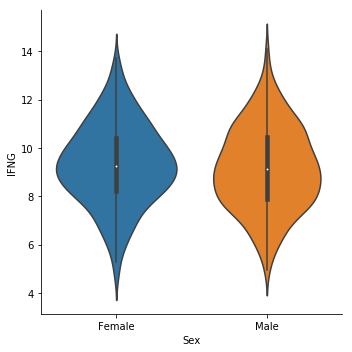

In [10]:
dt_subset = dt.loc[dt['stimulus']=='E.coli',:]
sns.catplot(x="Sex", y="IFNG", kind="violin", data=dt_subset);

Сложно сказать однозначно... Что тут можно сделать? 

Задача 3. Проверим, является ли различие в средней экспресии IFNG у мужчин и женщин при E.coli статистически значимым.
Каким тестом тут лучше воспользоваться и почему?  (при уровне значимости $\alpha  = 0.05$)

In [11]:
#Task 3 solution
_, pval = sc.stats.ttest_ind(dt_subset.loc[(dt_subset['Sex']=='Male') & (dt['stimulus']=='E.coli'),'IFNG'],
                             dt_subset.loc[(dt_subset['Sex']=='Female') & (dt['stimulus']=='E.coli'),'IFNG'])
print('pvalue is {}'.format(pval))
if pval < 0.05 :
    print('Yeap')
else:
    print('Nope')

pvalue is 0.15696511170328747
Nope


Задача 4. А интересно, у скольки еще генов различие в средней экспресии у мужчин и женщин при E.coli статистически значимым (при уровне значимости $\alpha  = 0.05$). Не будем усложнять себе жизнь и воспользуемся поправкой Бонферрони

In [12]:
#Task 4 solution
from statsmodels.sandbox.stats.multicomp import multipletests
gene_lists = dt_subset.columns.values[210:-1]
pvals_list = []
for gene in gene_lists:
    _, pval = sc.stats.mannwhitneyu(dt_subset.loc[dt_subset['Sex']=='Male', gene], 
                                    dt_subset.loc[dt_subset['Sex']=='Female', gene])
    pvals_list.append(pval)
p_adjusted = multipletests(pvals_list, method='bonferroni')[1]
passed_genes = sum(p_adjusted<0.05)
print('{} genes are different between males and females.'.format(passed_genes))

231 genes are different between males and females.


Отлично, но вернемся к IFNG. Добавим к рассмотрниею следующие параметры - Age, PhysicalActivity, BMI, Smoking, Education, LivesWithPartner. Как можно заметить, некоторые из них категориальные, некоторые - числовые. Тем интересней!

Задача 5. Рассмотрите уровень экспресии IFNG (при E.coli)  в зависимости от каждого из вышеназванных параметров. 
Какой вывод можно сделать? А если дополнительно разбить с учетом пола? 

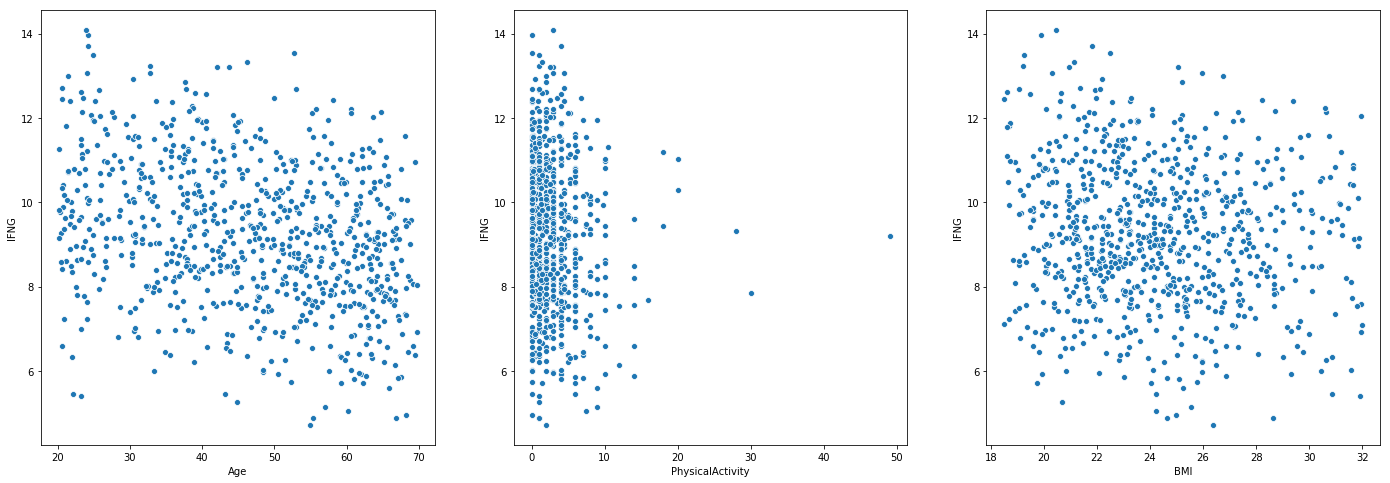

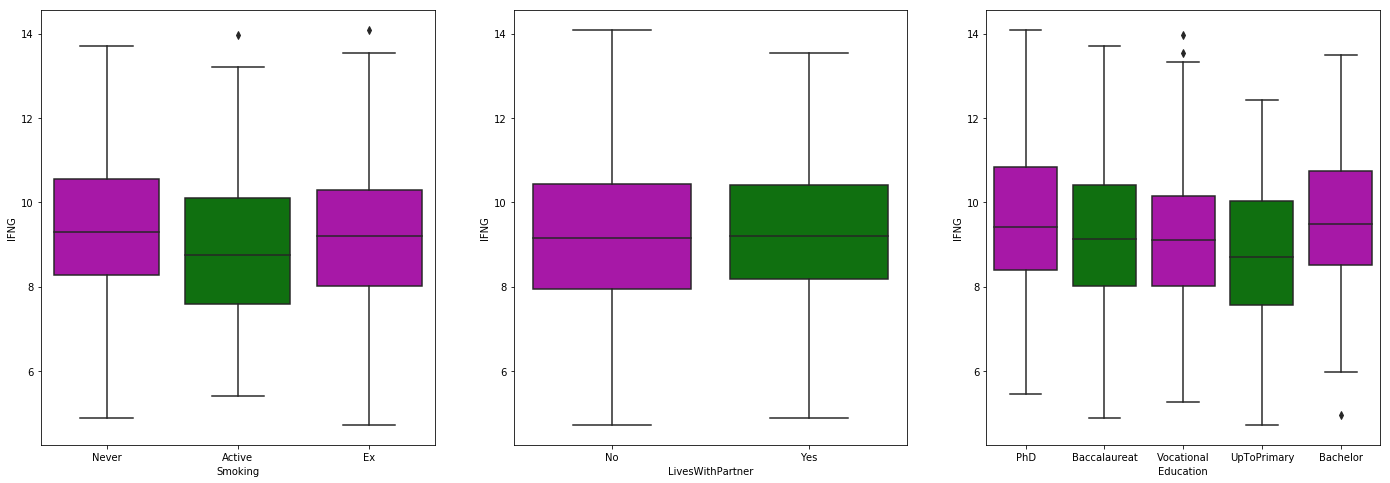

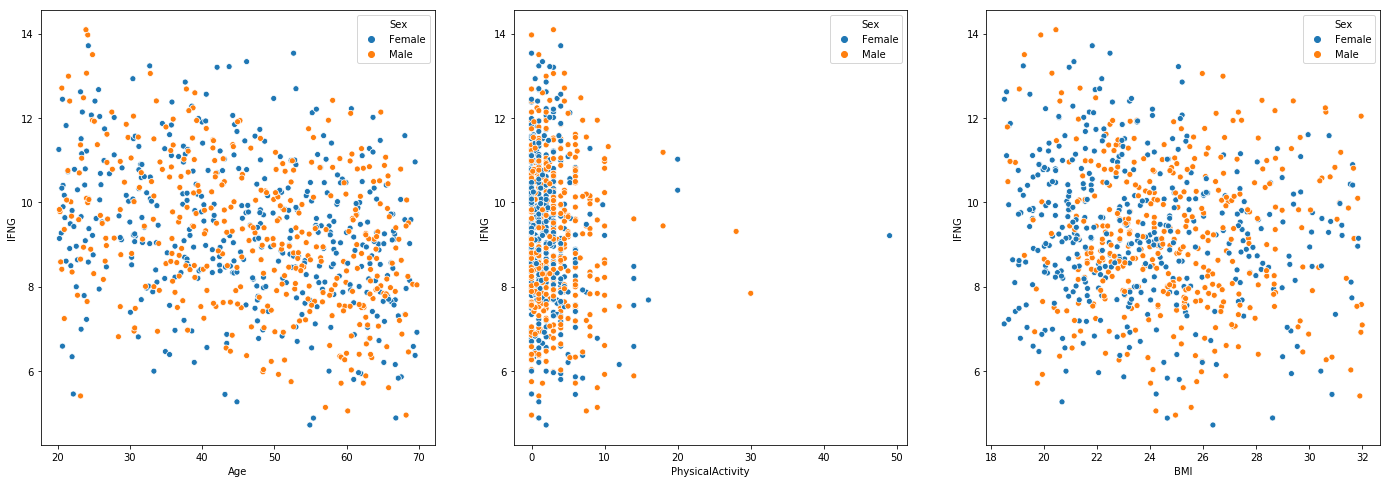

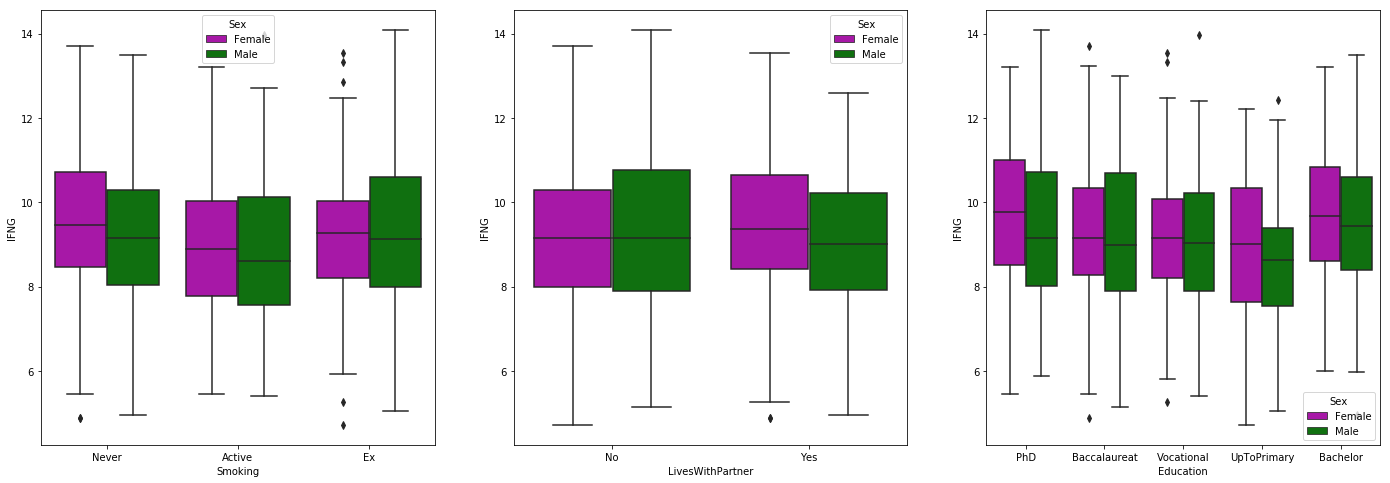

In [13]:
#Task 5 solution
fontsize=18
subset_data = dt.loc[dt['stimulus']=='E.coli', ['Age','PhysicalActivity','BMI','Smoking','Sex',
                                                'LivesWithPartner','Education', 'IFNG']]
# Plot sepal with as a function of sepal_length across days
numeric_columns  = ['Age','PhysicalActivity','BMI']
cat_columns  = ['Smoking','LivesWithPartner','Education']
f, ax = plt.subplots(1, len(numeric_columns), figsize=(24, 8))
for idx, numberic_col in enumerate(numeric_columns):
    sns.scatterplot(x=numberic_col, y="IFNG", data=subset_data, ax=ax[idx])
plt.show()
f, ax = plt.subplots(1, len(cat_columns), figsize=(24, 8))    
for idx, cat_col in enumerate(cat_columns):
    sns.boxplot(x=cat_col, y="IFNG", palette=["m", "g"],
            data=subset_data, ax=ax[idx])
plt.show()    
f, ax = plt.subplots(1, len(numeric_columns), figsize=(24, 8))
for idx, numberic_col in enumerate(numeric_columns):
    g = sns.scatterplot(x=numberic_col, y="IFNG", hue="Sex", data=subset_data, ax=ax[idx])
plt.show()
f, ax = plt.subplots(1, len(cat_columns), figsize=(24, 8))      
for idx, cat_col in enumerate(cat_columns):
    g = sns.boxplot(x=cat_col, y="IFNG",
            hue="Sex", palette=["m", "g"],
            data=subset_data, ax=ax[idx])
plt.show()

Задача 6. Для того, чтобы рассматривать экспрессию между несколькими группами, нам понадобится знание диспресионного анализа. 
Проверьте, можем ли мы утверждать, что уровень экспресии IFNG не зависит от курения (без разбиения по полу) (используейте пакет $statsmodels$). Дополнительно проведите Tukey hsd чтобы оценить разницу между группами

In [14]:
#Task 6 solution
f_value, p_value = sc.stats.f_oneway(subset_data.loc[subset_data['Smoking']=='Never','IFNG'].values,
                                     subset_data.loc[subset_data['Smoking']=='Active','IFNG'].values, 
                                     subset_data.loc[subset_data['Smoking']=='Ex','IFNG'].values)
print('One way anove p value {}'.format(p_value))
print(pairwise_tukeyhsd(subset_data['IFNG'], subset_data['Smoking']))

One way anove p value 0.013850418823482822
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
Active   Ex    0.2904   -0.123 0.7039 False 
Active Never   0.4587   0.0893 0.8281  True 
  Ex   Never   0.1682  -0.1618 0.4983 False 
--------------------------------------------


В последующих шагах по постараемся воспроизвести основные результаты статьи  Piasecka, E. et al. Natural variation in the parameters of innate immune cells is preferentially driven by genetic factors resource. Nat. Immunol. 19, 302-314 (2018), опубликованной в Nature Genetics. Далее мы работаем с стимулом NS, то есть с изначальным иммуным ответом.

In [15]:
dt_ns  = dt.loc[dt['stimulus']=='NS',:]

Большое Задание 1. Рассмотрите зависимости между предложенными негентическими переменными в этом датасете. Для это сделаете попарные линейные модели и в качестве зависимости возьмите $R^2$. При работе с категориальными переменными, используйте OHE стратегию и используйте их только как предикторы. (Хотя в случае бинарного лейбла можно сделать логрегрессию)

In [16]:
nongenetic_columns = ['Age', 'OwnsHouse',
                      'PhysicalActivity', 'Sex', 'LivesWithPartner', 'LivesWithKids',
                      'BornInCity', 'Inbreeding', 'BMI', 'CMVPositiveSerology', 'FluIgG',
                      'MetabolicScore', 'LowAppetite', 'TroubleConcentrating',
                      'TroubleSleeping', 'HoursOfSleep', 'Listless', 'UsesCannabis',
                      'RecentPersonalCrisis', 'Smoking', 'Employed', 'Education',
                      'DustExposure', 'Income',
                      'DepressionScore', 'HeartRate',
                      'Temperature']

Feature Age, total features 436, top 5 account for 3.2378580323785804
Feature OwnsHouse, total features 2, top 5 account for 100.0
Can use as category

Feature PhysicalActivity, total features 57, top 5 account for 59.40224159402241
Feature Sex, total features 2, top 5 account for 100.0
Can use as category

Feature LivesWithPartner, total features 2, top 5 account for 100.0
Can use as category

Feature LivesWithKids, total features 2, top 5 account for 100.0
Can use as category

Feature BornInCity, total features 2, top 5 account for 100.0
Can use as category

Feature Inbreeding, total features 803, top 5 account for 0.6226650062266501
Feature BMI, total features 455, top 5 account for 3.8605230386052303
Feature CMVPositiveSerology, total features 2, top 5 account for 100.0
Can use as category

Feature FluIgG, total features 796, top 5 account for 1.2453300124533002
Feature MetabolicScore, total features 5, top 5 account for 100.0
Can use as category

Feature LowAppetite, total feature

('Sex', 'MetabolicScore')
MetabolicScore is categorical, skip as dependent
('Sex', 'LowAppetite')
LowAppetite is categorical, skip as dependent
('Sex', 'TroubleConcentrating')
TroubleConcentrating is categorical, skip as dependent
('Sex', 'TroubleSleeping')
TroubleSleeping is categorical, skip as dependent
('Sex', 'HoursOfSleep')
Sex is categorical, making dummy variables
('Sex', 'Listless')
Listless is categorical, skip as dependent
('Sex', 'UsesCannabis')
UsesCannabis is categorical, skip as dependent
('Sex', 'RecentPersonalCrisis')
RecentPersonalCrisis is categorical, skip as dependent
('Sex', 'Smoking')
Smoking is categorical, skip as dependent
('Sex', 'Employed')
Employed is categorical, skip as dependent
('Sex', 'Education')
Education is categorical, skip as dependent
('Sex', 'DustExposure')
DustExposure is categorical, skip as dependent
('Sex', 'Income')
Income is categorical, skip as dependent
('Sex', 'DepressionScore')
DepressionScore is categorical, skip as dependent
('Sex', 

('MetabolicScore', 'BMI')
MetabolicScore is categorical, making dummy variables
('MetabolicScore', 'CMVPositiveSerology')
CMVPositiveSerology is categorical, skip as dependent
('MetabolicScore', 'FluIgG')
MetabolicScore is categorical, making dummy variables
('MetabolicScore', 'LowAppetite')
LowAppetite is categorical, skip as dependent
('MetabolicScore', 'TroubleConcentrating')
TroubleConcentrating is categorical, skip as dependent
('MetabolicScore', 'TroubleSleeping')
TroubleSleeping is categorical, skip as dependent
('MetabolicScore', 'HoursOfSleep')
MetabolicScore is categorical, making dummy variables
('MetabolicScore', 'Listless')
Listless is categorical, skip as dependent
('MetabolicScore', 'UsesCannabis')
UsesCannabis is categorical, skip as dependent
('MetabolicScore', 'RecentPersonalCrisis')
RecentPersonalCrisis is categorical, skip as dependent
('MetabolicScore', 'Smoking')
Smoking is categorical, skip as dependent
('MetabolicScore', 'Employed')
Employed is categorical, skip

('UsesCannabis', 'MetabolicScore')
MetabolicScore is categorical, skip as dependent
('UsesCannabis', 'LowAppetite')
LowAppetite is categorical, skip as dependent
('UsesCannabis', 'TroubleConcentrating')
TroubleConcentrating is categorical, skip as dependent
('UsesCannabis', 'TroubleSleeping')
TroubleSleeping is categorical, skip as dependent
('UsesCannabis', 'HoursOfSleep')
UsesCannabis is categorical, making dummy variables
('UsesCannabis', 'Listless')
Listless is categorical, skip as dependent
('UsesCannabis', 'RecentPersonalCrisis')
RecentPersonalCrisis is categorical, skip as dependent
('UsesCannabis', 'Smoking')
Smoking is categorical, skip as dependent
('UsesCannabis', 'Employed')
Employed is categorical, skip as dependent
('UsesCannabis', 'Education')
Education is categorical, skip as dependent
('UsesCannabis', 'DustExposure')
DustExposure is categorical, skip as dependent
('UsesCannabis', 'Income')
Income is categorical, skip as dependent
('UsesCannabis', 'DepressionScore')
Dep

('DepressionScore', 'CMVPositiveSerology')
CMVPositiveSerology is categorical, skip as dependent
('DepressionScore', 'FluIgG')
DepressionScore is categorical, making dummy variables
('DepressionScore', 'MetabolicScore')
MetabolicScore is categorical, skip as dependent
('DepressionScore', 'LowAppetite')
LowAppetite is categorical, skip as dependent
('DepressionScore', 'TroubleConcentrating')
TroubleConcentrating is categorical, skip as dependent
('DepressionScore', 'TroubleSleeping')
TroubleSleeping is categorical, skip as dependent
('DepressionScore', 'HoursOfSleep')
DepressionScore is categorical, making dummy variables
('DepressionScore', 'Listless')
Listless is categorical, skip as dependent
('DepressionScore', 'UsesCannabis')
UsesCannabis is categorical, skip as dependent
('DepressionScore', 'RecentPersonalCrisis')
RecentPersonalCrisis is categorical, skip as dependent
('DepressionScore', 'Smoking')
Smoking is categorical, skip as dependent
('DepressionScore', 'Employed')
Employed 

Text(0.5, 1.0, 'Dependency matrix')

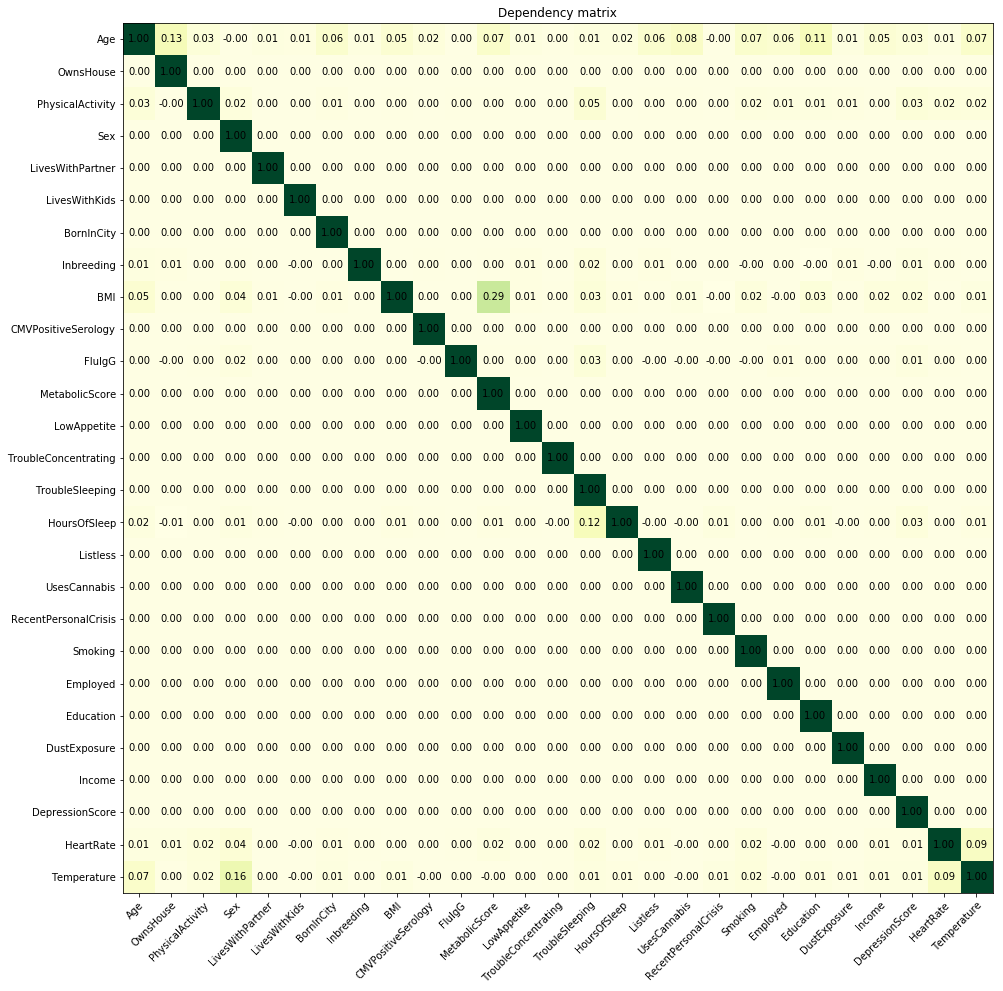

In [17]:
#Big task 1 solution
#make combinations of feature-outcome
combinations =  list(itertools.permutations(nongenetic_columns, 2))
#make zero matrix for results
dep_matrix = np.zeros((len(nongenetic_columns),len(nongenetic_columns)))
#self-self is 1
np.fill_diagonal(dep_matrix, 1)
idx_columns = dict(zip(nongenetic_columns, np.arange(len(nongenetic_columns))))
#identify which of the columns as categorical
cat_features = []
for col_ in nongenetic_columns:
    vals = dt_ns[col_].value_counts()
    n_features = len(set(vals.index))
    top_5_features = 100*vals.values[:5].sum()/vals.sum()
    print('Feature {}, total features {}, top 5 account for {}'.format(col_,n_features,top_5_features))
    if n_features<=5 or top_5_features>=96:
        cat_features.append(col_)
        print('Can use as category\n')
print('='*50)
print(' '*20+'Making linear regression'+' '*20)
print('='*50)
#columns - predictors (first), rows = dependent (second)
for pair in combinations:
    print(pair)
    if pair[1] in cat_features:
        print('{} is categorical, skip as dependent'.format(pair[1]))
        continue
    if pair[0] in cat_features:
        print('{} is categorical, making dummy variables'.format(pair[0]))
        X = pd.get_dummies(dt_ns[pair[0]].astype(object))
        y = dt_ns[pair[1]]
        reg = LinearRegression().fit(X, y)
        r_squared = reg.score(X,y)
        dep_matrix[idx_columns[pair[1]],idx_columns[pair[0]]] = r_squared
    else:
        print('{} is numeric'.format(pair[0]))
        X = dt_ns[pair[0]].values.reshape(-1, 1)
        y = dt_ns[pair[1]].values
        reg = LinearRegression().fit(X, y)
        r_squared = reg.score(X,y)
        dep_matrix[idx_columns[pair[1]],idx_columns[pair[0]]] = r_squared

f, ax = plt.subplots(1, 1, figsize=(16, 16))
ax.imshow(dep_matrix, cmap="YlGn");
ax.set_xticks(np.arange(len(nongenetic_columns)));
ax.set_yticks(np.arange(len(nongenetic_columns)));
# ... and label them with the respective list entries
ax.set_xticklabels(nongenetic_columns);
ax.set_yticklabels(nongenetic_columns);
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor");
for i in range(len(nongenetic_columns)):
    for j in range(len(nongenetic_columns)):
        text = ax.text(j, i, '%.2f' % dep_matrix[i, j],
                       ha="center", va="center", color="k")

ax.set_title("Dependency matrix")

Большое задание 1.1. Теперь мы посмотрим на корреляцию между различными MFI

In [18]:
MFI_cols = [x for x in dt_ns.columns.values if 'MFI_' in x]

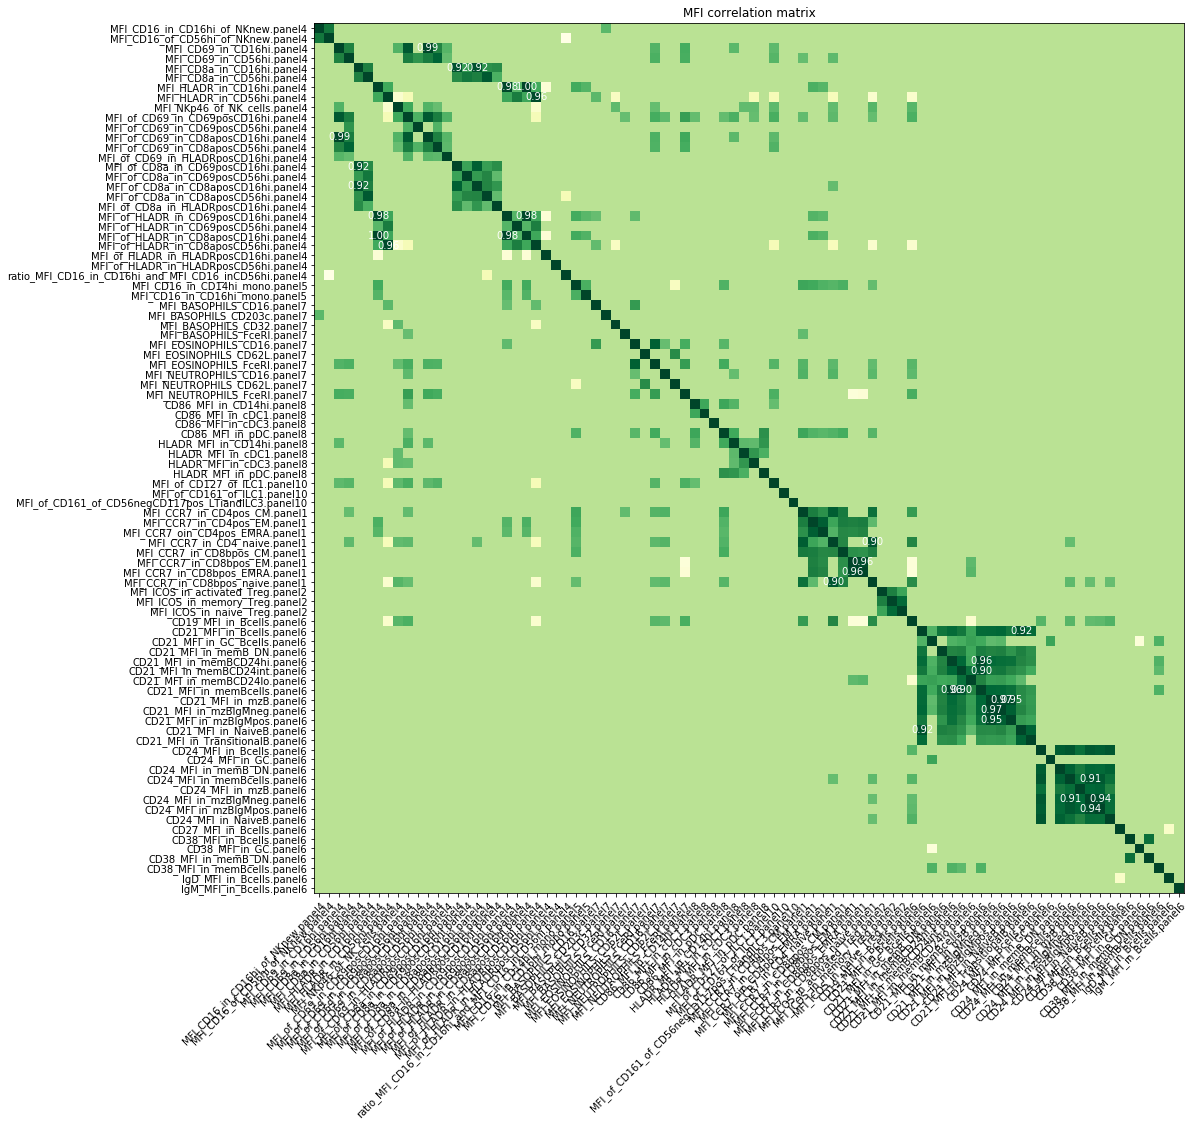

In [54]:
#Big task 1.1 solution 
corr_matrix = dt_ns[MFI_cols].corr()
corr_matrix.values[np.abs(corr_matrix.values)<0.3] = 0
f, ax = plt.subplots(1, 1, figsize=(16, 16))
ax.imshow(corr_matrix.values, cmap="YlGn");
ax.set_xticks(np.arange(len(MFI_cols)));
ax.set_yticks(np.arange(len(MFI_cols)));
# ... and label them with the respective list entries
ax.set_xticklabels(MFI_cols);
ax.set_yticklabels(MFI_cols);
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor");
for i in range(len(MFI_cols)):
    for j in range(len(MFI_cols)):
        if corr_matrix.values[i, j]>=0.9 and i!=j:
            text = ax.text(j, i, '%.2f' % corr_matrix.values[i, j],
                           ha="center", va="center", color="w")

ax.set_title("MFI correlation matrix");
#Select feature if only all correlation are less than 0.6  - quick and dirty 
noncorrelated_features = corr_matrix.apply(lambda x: all(x[x!=1]<=0.8))
noncorrelated_features = noncorrelated_features.index[noncorrelated_features==True].tolist()

Большое задание 2. Теперь сделаем регресионные модели для каждого из этих показателей.

In [55]:
factors = ['Age', 'Sex', 'BMI', 'CMVPositiveSerology', 'MetabolicScore', 'Smoking']
dt_ns_regres = dt_ns[factors+noncorrelated_features]

In [56]:
#solution
cat_features = ['Sex','CMVPositiveSerology','Smoking']
numeric_features = ['Age','BMI','MetabolicScore']
dt_ns_regres[numeric_features] = scale(dt_ns_regres[numeric_features])
for col_ in cat_features:
    dt_ns_regres[col_] = dt_ns_regres[col_].astype(object)
X_cat = pd.get_dummies(dt_ns_regres[cat_features])
X_cat = X_cat.drop(['Sex_Female','CMVPositiveSerology_No','Smoking_Never'],axis=1)
X = pd.concat([X_cat, dt_ns_regres[numeric_features]],axis=1)
Y = np.log(dt_ns_regres[noncorrelated_features]+1)
data = pd.concat([X,Y],axis=1)
data = data.dropna(axis=0)
data.columns = [x.replace('.','_') for x in data.columns.values]
noncorrelated_features = [x.replace('.','_') for x in noncorrelated_features]
for MFI_ in noncorrelated_features:
    lm_smf = smf.ols(formula='{} ~ Sex_Male + CMVPositiveSerology_Yes + Smoking_Active + Smoking_Ex + Age + BMI + MetabolicScore'.format(MFI_), 
                     data=data).fit()
    rsquared = lm_smf.rsquared_adj
    print('{}, rsuared {}'.format(MFI_, rsquared))

MFI_CD16_in_CD16hi_of_NKnew_panel4, rsuared 0.06268979754876158
MFI_CD16_of_CD56hi_of_NKnew_panel4, rsuared 0.03490538380285935
MFI_NKp46_of_NK_cells_panel4, rsuared 0.04766500355686776
MFI_of_CD69_in_CD69posCD56hi_panel4, rsuared 0.0014326959919098714
MFI_of_CD69_in_HLADRposCD16hi_panel4, rsuared 0.030047586413152527
MFI_of_CD8a_in_CD69posCD56hi_panel4, rsuared -0.012842528857689883
MFI_of_CD8a_in_HLADRposCD16hi_panel4, rsuared 0.03771789614949739
MFI_of_HLADR_in_CD69posCD56hi_panel4, rsuared 0.0017398000112711642
MFI_of_HLADR_in_HLADRposCD16hi_panel4, rsuared -0.007346960209860587
MFI_of_HLADR_in_HLADRposCD56hi_panel4, rsuared -0.002032391560914615
ratio_MFI_CD16_in_CD16hi_and_MFI_CD16_inCD56hi_panel4, rsuared -0.01438105149267721
MFI_CD16_in_CD14hi_mono_panel5, rsuared 0.0012659673196971921
MFI_CD16_in_CD16hi_mono_panel5, rsuared 0.04931534662835235
MFI_BASOPHILS_CD16_panel7, rsuared 0.04432690589406518
MFI_BASOPHILS_CD203c_panel7, rsuared 0.05995469980205004
MFI_BASOPHILS_CD32_pane